# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [7]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True
            
    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()


## Exercise 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [3]:
def thresholdImage(I,s):  #fonction de seuillage 
    """ Array*int -> Array """
    I_copy = I.copy()
    I_copy[I_copy < s] = 0
    I_copy[I_copy >= s] = 1    

    return I_copy

def SobelDetector(I, s):
    """ Array*double -> Array """
    Sx = np.array([[1,0,-1],[2, 0, -2],[1, 0, -1]])
    Sy = Sx.T
    Gx = convolve2d(I, Sx, mode='same')
    Gy = convolve2d(I, Sy, mode='same')
    
    norme = np.sqrt(Gx**2 + Gy**2) #calcul de la norme du gradient 

    norme_seuillée = thresholdImage(norme, s) #seuillage de la norme du gradient 

    return norme_seuillée


2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [4]:
def ImagePadding(M,p): #fonction pour faire le padding par copie 
    
    I = M.copy()
         
    for i in range(p): 
        
        L1 = I[0, :]  # Première ligne de l'image
        L2 = I[-1, :]  # Dernière ligne
        I = np.vstack((L1, I, L2))

        C1 = I[:, 0]  # Première colonne de l'image
        C2 = I[:, -1]  # Dernière colonne
        I = np.hstack((C1[:, np.newaxis], I, C2[:, np.newaxis]))
        
    return I     
                 
                  
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    
    laplacian_filter = np.array([[0,1,0],[1, -4, 1],[0, 1, 0]])
    L = convolve2d(I, laplacian_filter, mode="same") #calcul du laplacien de l'image 

    #padding
    padded_img = ImagePadding(L,1)
    
    contours = np.zeros((L.shape[0], L.shape[1])) 
    
    for i in range(1,L.shape[0] + 1):
        for j in range(1,L.shape[1] + 1):
            
            Il = padded_img[i-1:i+1,j-1:j+1] #on prend le voisinage du pixel 
            max_Il = np.max(Il)
            min_Il = np.min(Il)

            if (max_Il - min_Il) > s and max_Il > 0 and min_Il < 0: #condition de passage par 0
                contours[i-1,j-1] = 1
            
    return contours



In [5]:
lena = np.array(Image.open("img/lena.png"))

In [6]:
niceDisplay14([SobelDetector(lena, 70), SobelDetector(lena, 50), SobelDetector(lena, 90), SobelDetector(lena, 120)], ['Filtre de Sobel, s=70', 'Filtre de Sobel, s=50','Filtre de Sobel, s=90','Filtre de Sobel, s=120'])
niceDisplay14([LaplacianDetector(lena, 70), LaplacianDetector(lena, 50), LaplacianDetector(lena, 90), LaplacianDetector(lena, 120)], ['Filtre Laplacien, s=70', 'Filtre Laplacien, s=50','Filtre Laplacien, s=90','Filtre Laplacien, s=120'])


<IPython.core.display.Javascript object>

* On peut remarquer que le filtre de Sobel est efficace pour détecter des contours nets et bien définis. Il est moins sensible au bruit que le filtre Laplacien (il produit moins de faux positifs).
* On remarque que le laplacien permet de détecter des détails fins dans l'image, mais qu'il est plus sensible au bruit. Il réagit à n'importe quelle variation d'intensité, y compris le bruit (il produit plus de faux positifs).

* Lorsqu'on augmente la valeur de s (seuil) pour le filtre de Sobel, nous pouvons voir que les contours deviennent plus fins mais que nous perdons certains détails. Les contours moins prononcés sont ignorés, et seuls les contours très nets sont détectés. Pour s plus bas, nous avons plus de bruit et de faux positifs. 
* Lorsqu'on augmente la valeur de s (seuil) pour le laplacien, nous pouvons voir que le bruit est réduit mais que beaucoup de détails sont perdus. Ainsi, il est important de trouver un compromis entre réduction du bruit et niveau de détails détectés.  

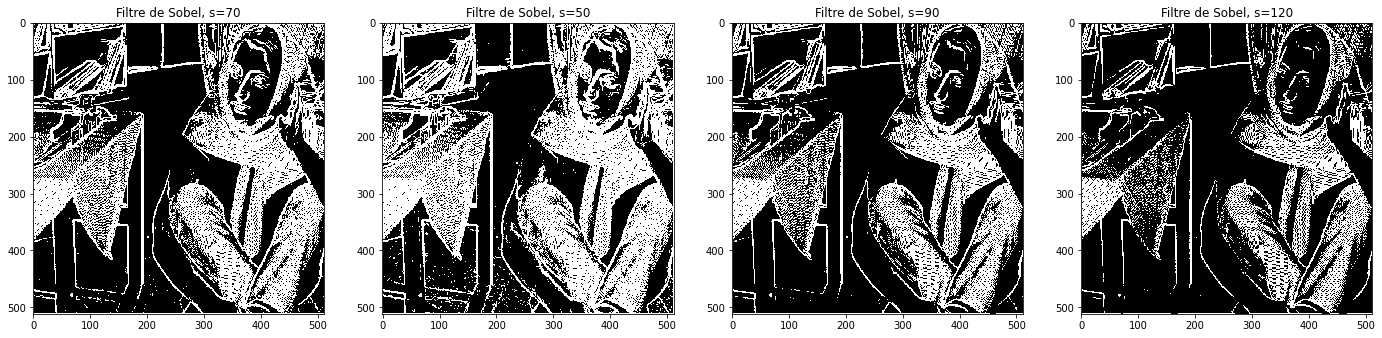

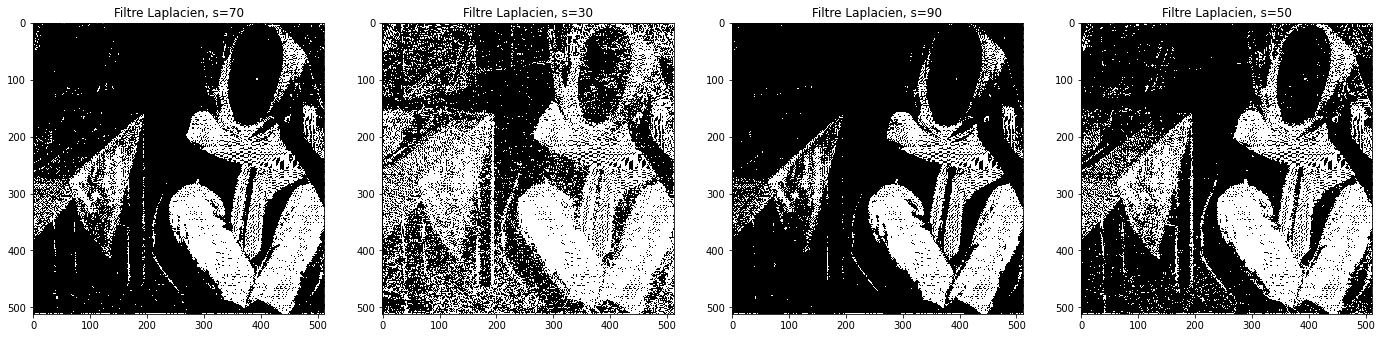

In [6]:
barbara = np.array(Image.open("img/barbara.png"))
niceDisplay14([SobelDetector(barbara, 70), SobelDetector(barbara, 50), SobelDetector(barbara, 90), SobelDetector(barbara, 120)], ['Filtre de Sobel, s=70', 'Filtre de Sobel, s=50','Filtre de Sobel, s=90','Filtre de Sobel, s=120'])
niceDisplay14([LaplacianDetector(barbara, 70), LaplacianDetector(barbara, 30), LaplacianDetector(barbara, 90), LaplacianDetector(barbara, 50)], ['Filtre Laplacien, s=70', 'Filtre Laplacien, s=30','Filtre Laplacien, s=90','Filtre Laplacien, s=50'])

* Dans le cas de l'image Barbara, nous pouvons voir que le filtre de Sobel fait mieux que le Laplacien. En effet, le filtre de Sobel arrive à détecter les contours nets et bien définis (comme les traits du visage). En augmentant la valeur du seuil, il donne des résultats de plus en plus satisfaisants (contours plus fins) mais nous perdons certains contours. Le Laplacien arrive beaucoup moins à identifier les traits du visage et est très affecté par le bruit. 
* Il est à noter que c'est une image assez difficile qui présente beaucoup de variations (notamment les motifs du foulard, du pantalon, etc.). 

* De manière générale, Sobel est utile pour détecter les contours bien définis et est moins sensible au bruit alors que le Laplacien arrive parfois à détecter des détails plus subtiles mais est très sensible au bruit. 


## Exercise 2: non maximum suppression

This exercise addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

In [1]:
%matplotlib notebook
#### your answer below
img_tools = np.array(Image.open("img/tools.png"))

Sx = np.array([[1,0,-1],[2, 0, -2],[1, 0, -1]]) #nous utilisons le filtre de Sobel
Sy = Sx.T

Gx_tools = convolve2d(img_tools, Sx, mode='same')
Gy_tools = convolve2d(img_tools, Sy, mode='same')    
norme_tools = np.sqrt(Gx_tools**2 + Gy_tools**2)
orientation_tools = orientation(Gx_tools, Gy_tools, norme_tools)


imshow_hot(orientation_tools)

NameError: name 'np' is not defined

Explain the different values given to a pixel by `orientation()`:

* Orientation() nous donne l'orientation du gradient pour chaque pixel. Les valeurs possibles sont 0, 𝜋/4, 𝜋/2 et 3𝜋/4 codées par les valeurs 1, 2, 3 et 4, 0 signifie que le gradient est nul. Cela se fait grâce a un produit scalaire entre le vecteur normalisé du gradient pour chaque pixel et les vecteurs unitaires des directions discrétisées.  
* imshow_hot() nous permet d'observer ces valeurs suivant un code couleur. 

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [7]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    
    G = np.zeros((Ig.shape)) 
    
    for i in range(1, Ig.shape[0]-1):
        for j in range(1, Ig.shape[1]-1):
            
            if Ior[i,j] == 1:            #Pour degré 0
                V = Ig[i,j-1:j+2]
                if Ig[i,j] == np.max(V):
                    G[i,j] = Ig[i,j]
            elif Ior[i,j] == 2:           #Pour degré pi/4
                V = np.array([Ig[i-1,j+1], Ig[i, j], Ig[i+1, j-1]])                
                if Ig[i,j] == np.max(V):
                    G[i,j] = Ig[i,j]
            elif Ior[i,j] == 3:           #Pour degré pi/2
                V = Ig[i-1:i+2, j]
                if Ig[i,j] == np.max(V):
                    G[i,j] = Ig[i,j]
            elif Ior[i,j] == 4:           #Pour degré 3pi/4 
                V = np.array([Ig[i-1,j-1], Ig[i, j], Ig[i+1, j+1]])
                if Ig[i,j] == np.max(V):
                    G[i,j] = Ig[i,j]
    return G

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


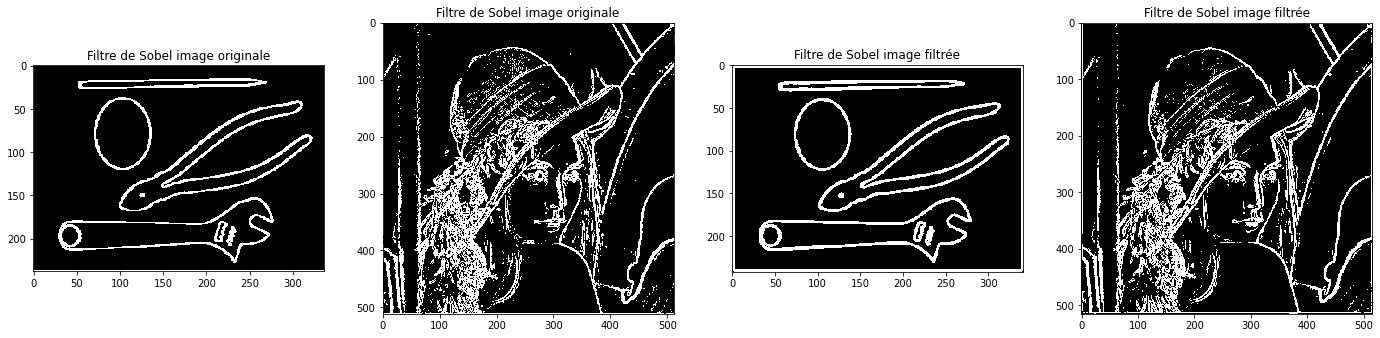

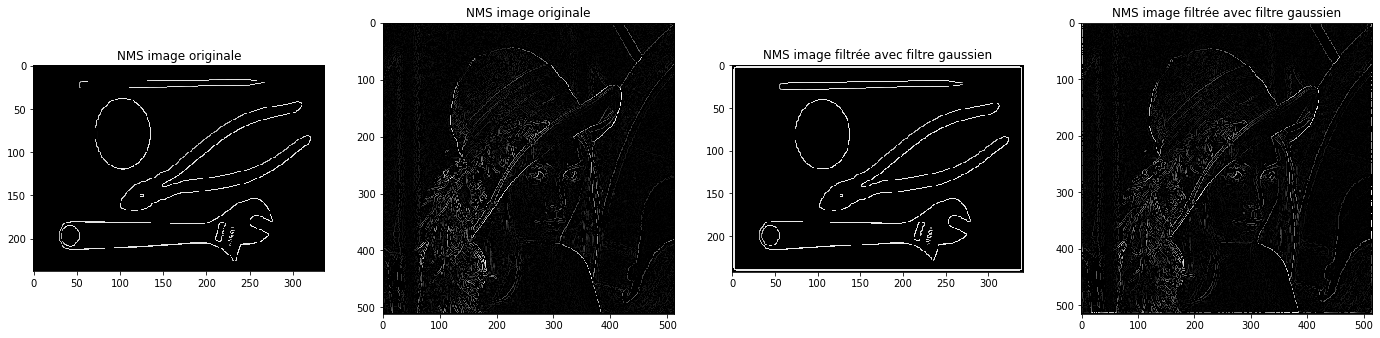

In [20]:
img_tools = np.array(Image.open("img/tools.png"))
img_tools_f = convolve2d(img_tools, gaussianKernel(0.5))
lena_f = convolve2d(lena, gaussianKernel(0.5))

images = []
titles = ["NMS image originale", "NMS image originale", 
          "NMS image filtrée avec filtre gaussien", "NMS image filtrée avec filtre gaussien"]

for I in [img_tools, lena, img_tools_f, lena_f]:
    Sx = np.array([[1,0,-1],[2, 0, -2],[1, 0, -1]])
    Sy = Sx.T
    Gx = convolve2d(I, Sx, mode='same')
    Gy = convolve2d(I, Sy, mode='same')
    G = np.sqrt(Gx**2 + Gy**2)
    Io = orientation(Gx, Gy, G)
    images.append(nms(G, Io))

niceDisplay14([SobelDetector(img_tools, 80), SobelDetector(lena, 80),  SobelDetector(img_tools_f, 80), SobelDetector(lena_f, 80)], ['Filtre de Sobel image originale', 'Filtre de Sobel image originale','Filtre de Sobel image filtrée', 'Filtre de Sobel image filtrée'])
niceDisplay14(images, titles)

* Nous pouvons voir que le filtre gaussien a pour effet de réduire le bruit tout en préservant les contours les plus marqués. Il laisse principalement les contours les plus nets. 
* Nous pouvons voir que l'étape NMS (non maxima supression) a pour effet de réduire l'épaisseur des contours. Elle permet d'obtenir des contours plus fins et plus nets, et permet d'éliminer certains détails indésirables. Mais dans le cas du NMS appliqué à l'image originale, certains contours sont ratés.   


4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

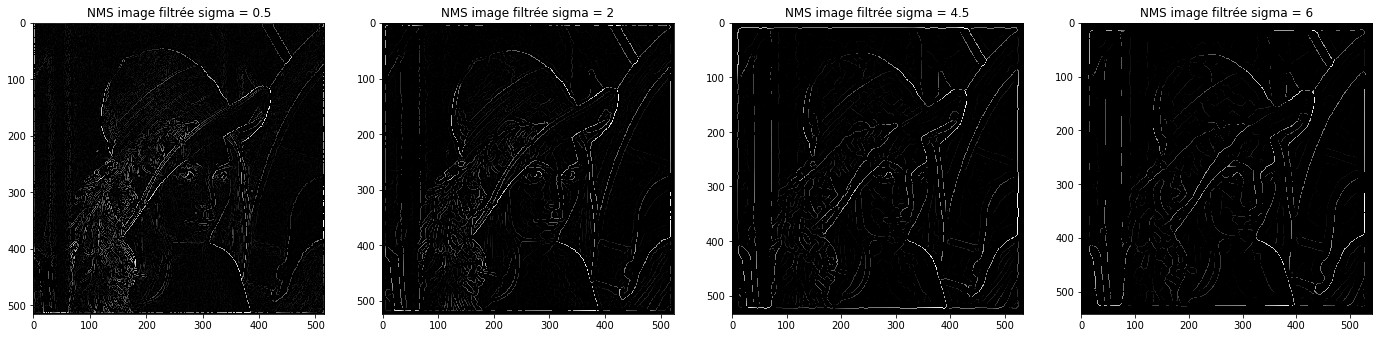

In [9]:
lena = np.array(Image.open('img/lena.png'))
lena_f =[]

for sigma in np.arange(0.5,6.5,1.5) :
    lena_f.append(convolve2d(lena, gaussianKernel(sigma)))
    

images = []
titles = ["NMS image filtrée sigma = 0.5", "NMS image filtrée sigma = 2", 
          "NMS image filtrée sigma = 4.5", "NMS image filtrée sigma = 6"]

for I in lena_f:
    Sx = np.array([[1,0,-1],[2, 0, -2],[1, 0, -1]])
    Sy = Sx.T
    Gx = convolve2d(I, Sx, mode='same')
    Gy = convolve2d(I, Sy, mode='same')
    G = np.sqrt(Gx**2 + Gy**2)
    Io = orientation(Gx, Gy, G)
    images.append(nms(G, Io))

niceDisplay14(images, titles)

* Nous savons que plus la valeur de sigma est grande, plus le lissage est important. Un lissage important signifie que les variations d'intensité fines sont davantage atténuées. Cela conduit à des contours plus épais et moins sensibles aux détails fins de l'image. L'application du NMS permet tout de même de réduire l'épaisseur des contours donc l'effet le plus indésirable dans ce cas est la perte de détails. 

## Exercise 3:  effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

<IPython.core.display.Javascript object>


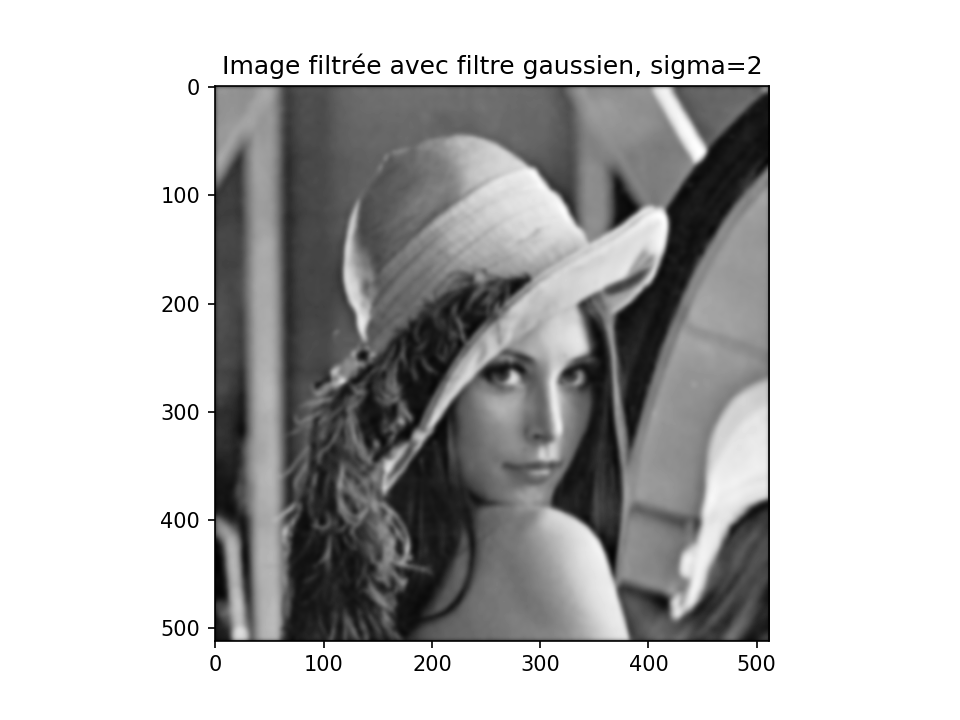

In [19]:
%matplotlib notebook
smoothed_lena = convolve2d(lena, gaussianKernel(2),'same')

imshow(smoothed_lena, "Image filtrée avec filtre gaussien, sigma=2")

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

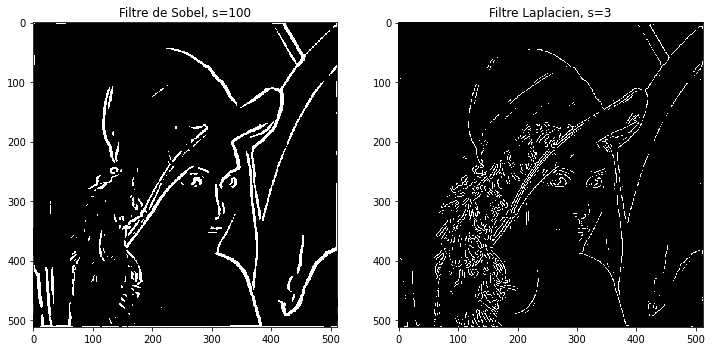

In [27]:
smoothed_lena = convolve2d(lena, gaussianKernel(2),'same')
niceDisplay14([SobelDetector(smoothed_lena, 100), LaplacianDetector(smoothed_lena, 3)], ['Filtre de Sobel, s=100', 'Filtre Laplacien, s=3'])

* Nous pouvons voir que l'application du filtre gaussien avant Sobel a pour effet l'épaississement des contours et la perte des détails fins mais également l'atténuation du bruit. 
* L'application du filtre gaussien avant le Laplacien a permis de réduire le bruit et de faire apparaitre certains détails fins mais il est à noter que le seuil s a dû être grandement réduit. Pour s encore plus petit, il fait apparaitre des faux contours.

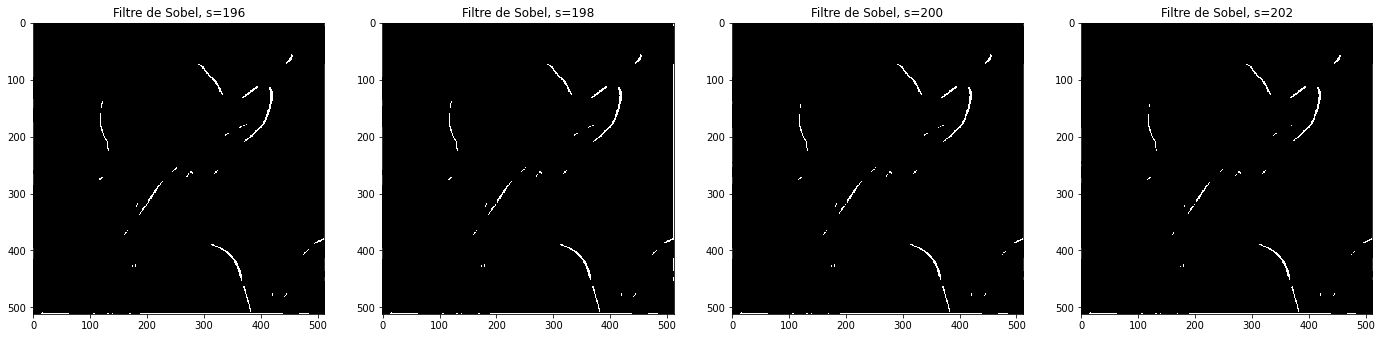

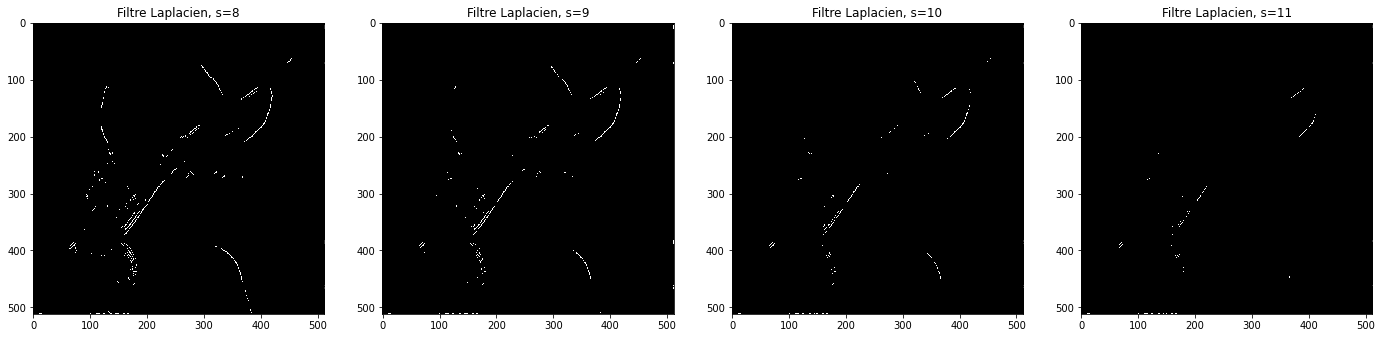

In [12]:
niceDisplay14([SobelDetector(smoothed_lena, 196), SobelDetector(smoothed_lena, 198), SobelDetector(smoothed_lena, 200), SobelDetector(smoothed_lena, 202)], ['Filtre de Sobel, s=196', 'Filtre de Sobel, s=198','Filtre de Sobel, s=200','Filtre de Sobel, s=202'])
niceDisplay14([LaplacianDetector(smoothed_lena, 8), LaplacianDetector(smoothed_lena, 9), LaplacianDetector(smoothed_lena, 10), LaplacianDetector(smoothed_lena, 11)], ['Filtre Laplacien, s=8', 'Filtre Laplacien, s=9','Filtre Laplacien, s=10','Filtre Laplacien, s=11'])

Nous pouvons considérer que nous avons presque les mêmes contours détectés pour s=200 pour Sobel et pour s=8 pour le Laplacien.

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

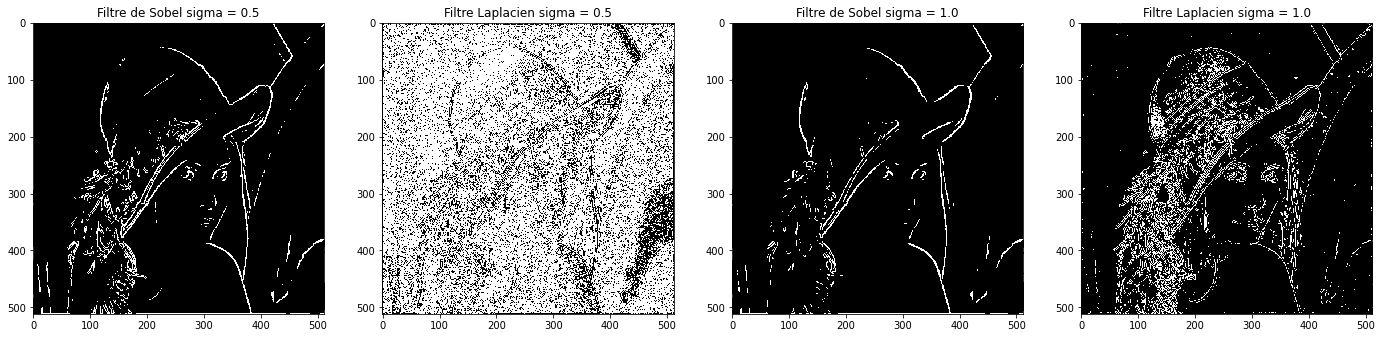

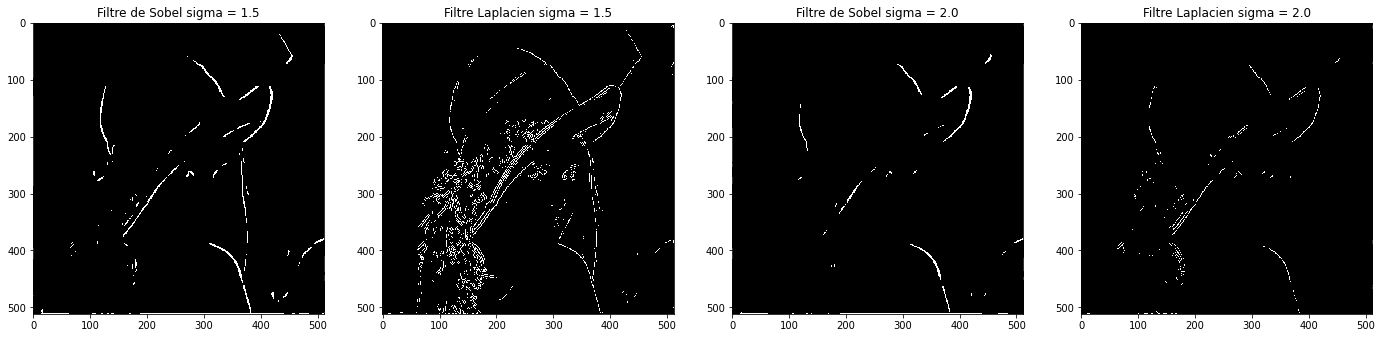

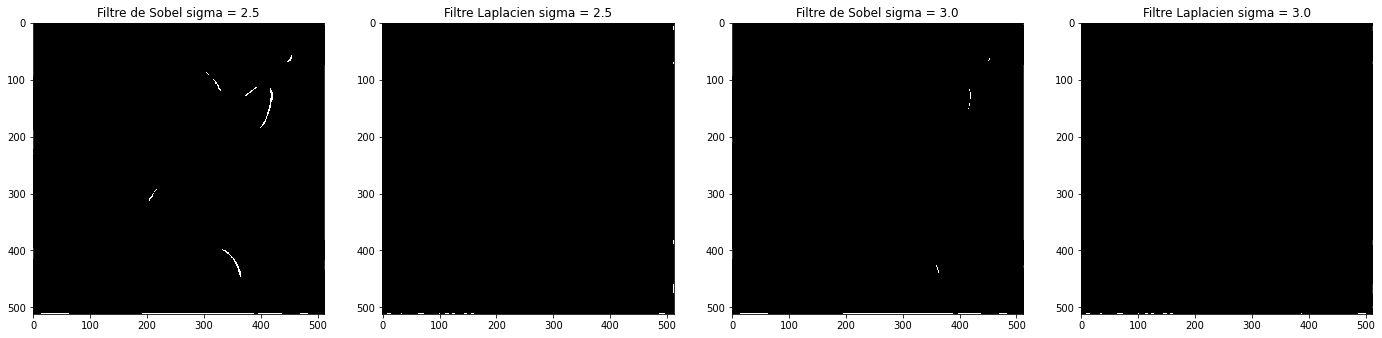

In [28]:
images = []
titles = []
for sigma in np.arange(0.5, 4, 0.5):
    smoothed_lena = convolve2d(lena, gaussianKernel(sigma),'same')

    images.append(SobelDetector(smoothed_lena, 200))
    titles.append(f"Filtre de Sobel sigma = {sigma}")

    images.append(LaplacianDetector(smoothed_lena, 8))
    titles.append(f"Filtre Laplacien sigma = {sigma}")

for i in range(4, len(images), 4):
    niceDisplay14(images[i-4:i], titles[i-4:i])

Nous pouvons voir que l'application du filtre gaussien a pour effet la diminution du bruit. Cependant, plus le lissage est fort, moins les détails fins sont détectés. De manière générale, Sobel est plus robuste aux variations du bruit que le Laplacien.

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

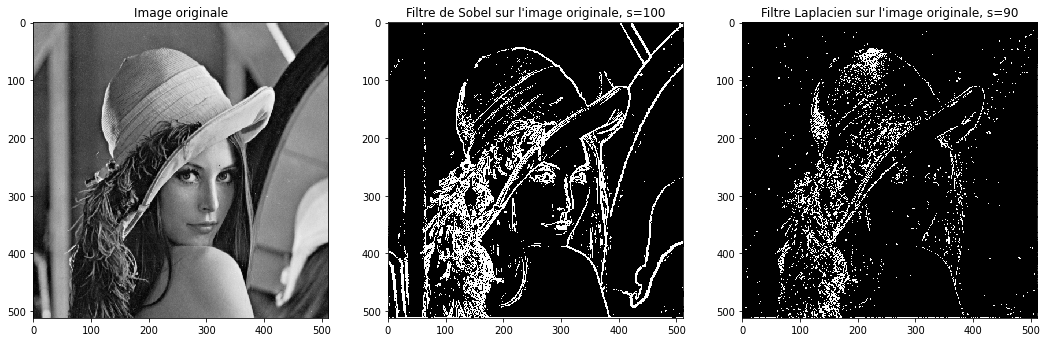

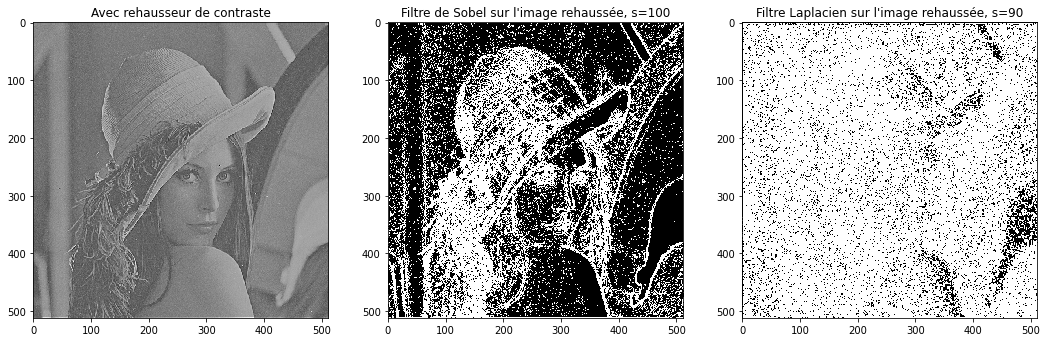

In [30]:
constrast_enhancer = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
lena2 = convolve2d(lena, constrast_enhancer, mode='same')
niceDisplay14(  [lena, SobelDetector(lena, 100), LaplacianDetector(lena, 90)], ['Image originale',  'Filtre de Sobel sur l\'image originale, s=100' , 'Filtre Laplacien sur l\'image originale, s=90'])
niceDisplay14( [lena2, SobelDetector(lena2, 100), LaplacianDetector(lena2, 90)], ['Avec rehausseur de contraste', 'Filtre de Sobel sur l\'image rehaussée, s=100', 'Filtre Laplacien sur l\'image rehaussée, s=90']) 

Nous pouvons voir que l'utilisation du filtre rehausseur avec les mêmes seuils n'est pas adaptée. Essayons de changer les seuils : 

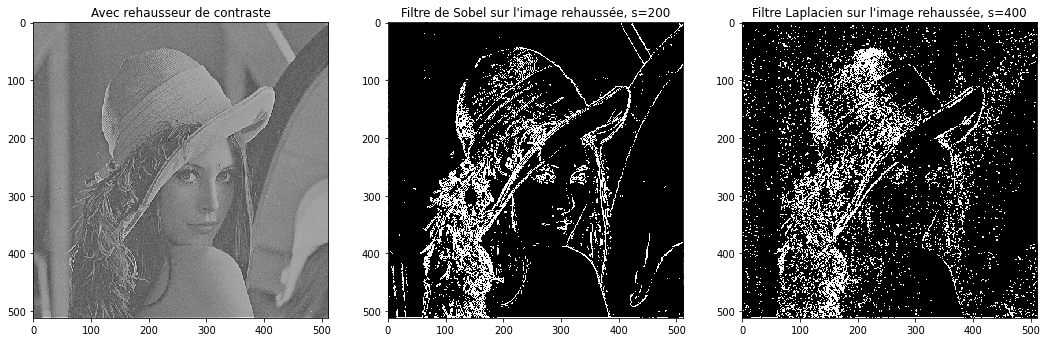

In [32]:
niceDisplay14( [lena2, SobelDetector(lena2, 250), LaplacianDetector(lena2, 400)], ['Avec rehausseur de contraste', 'Filtre de Sobel sur l\'image rehaussée, s=200', 'Filtre Laplacien sur l\'image rehaussée, s=400']) 

Le filtre rehausseur a permis de mettre en évidence plus de contours dans le cas de Sobel (avec le seuil adapté).

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

(512, 512)


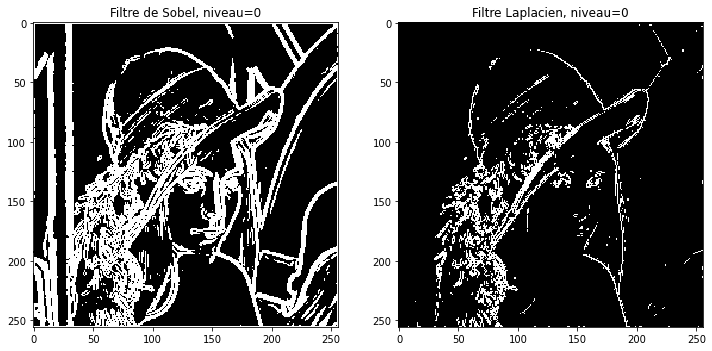

(256, 256)


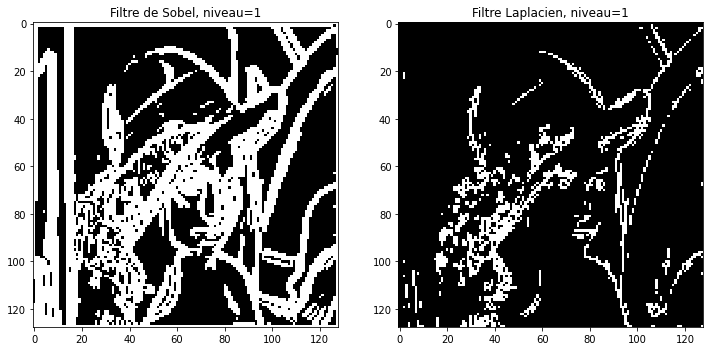

(128, 128)


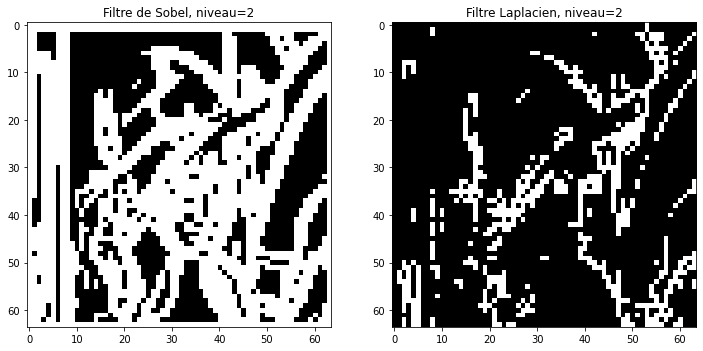

(64, 64)


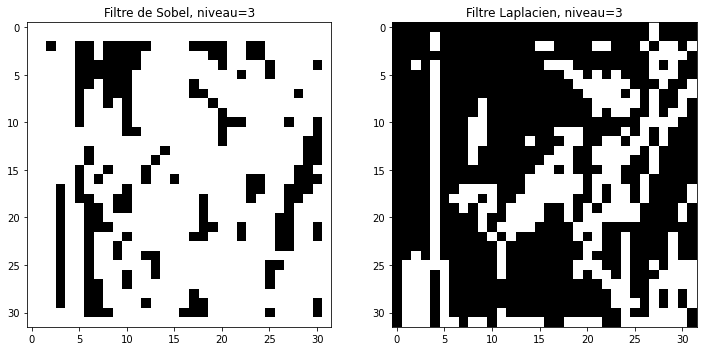

(32, 32)


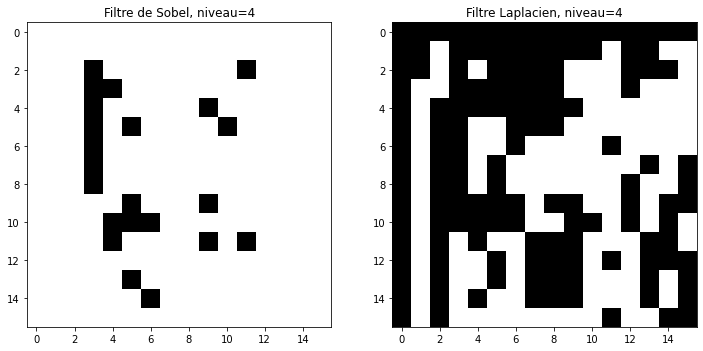

(16, 16)


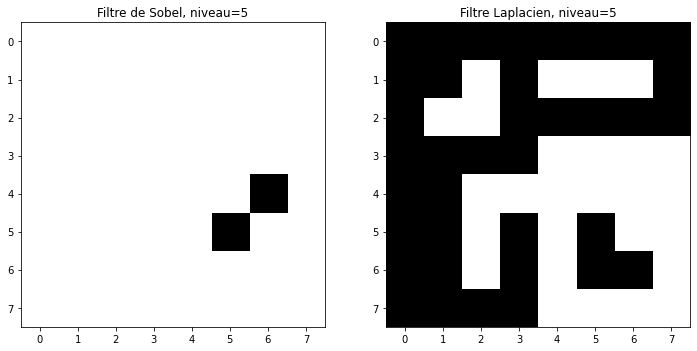

(8, 8)


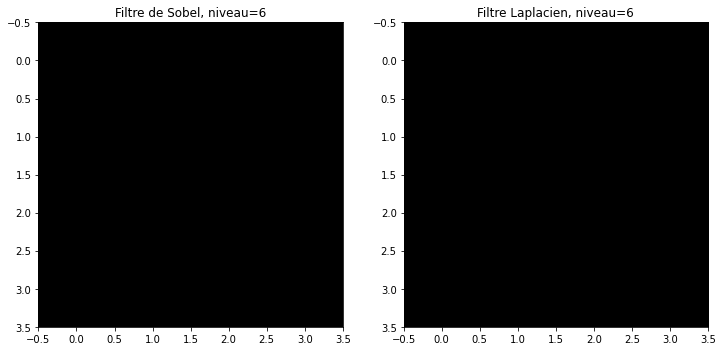

In [17]:
def subSample2(I):
    """ Array -> Array """
    return I[::2,::2]


def multiresolution_decomposition (I):
    
    niveau = 0    
    
    while (I.shape[0]>=8):
        
        I_f = convolve2d(I, gaussianKernel(1),mode='same')
        print(I_f.shape)
        subsampled_I = subSample2(I_f)
        niceDisplay14([SobelDetector(subsampled_I, 70), LaplacianDetector(subsampled_I, 70)],
                      [f'Filtre de Sobel, niveau={niveau}', f'Filtre Laplacien, niveau={niveau}'])
        niveau +=1
        I = subsampled_I

  

multiresolution_decomposition(lena)



* Nous pouvons voir que plus la résolution diminue, plus les contours sont épais et déformés, cela est dû à la perte d'information lors du sous-échantillonnage. 
* Nous pouvons voir que le Laplacien fournit tout de même des contours plus fins dans ce cas et qu'il est plutôt robuste à la perte de résolution, contrairement à Sobel.